In [1]:
import os
import re

import shutil
import codecs, json 
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import scipy as sp
from scipy import stats
import sklearn as sk
import time
from dypac import Dypac
import nilearn
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr
import nilearn.plotting as plotting

In [2]:
import hcp_utils as hcp

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


# Load connectome data

In [3]:
#path to matrices
path = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/all_features_992_Glasser.npz'

#path to subject IDs 
path_sub = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/subID_992.txt'

#path to behavioral data (analyzed in the analyze_behavior notebook)
path_behavior = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/Behavior/HCP_behavior_includeZscores.csv'

X_features = np.load(path)['a']
subject_IDs = np.loadtxt(path_sub)
df = pd.read_csv(path_behavior)

In [4]:
X_features.shape

(992, 379, 379)

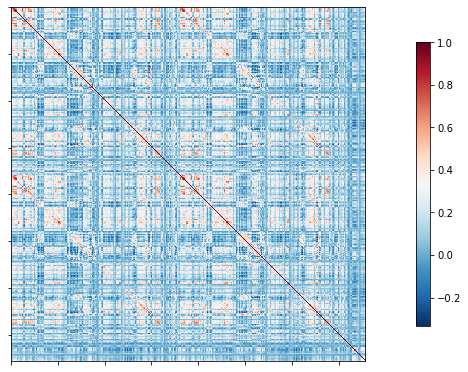

In [15]:
#Example how it looks for one subject
correlation_matrix = X_features[0]
# Mask the main diagonal for visualization:
# np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix)

# Equalize number of subjects in x_features and behavior

In [5]:
#Exclude subjects in the behavior data so it would be the same as the fMRI data
df = df[df['Subject'].isin(subject_IDs)]

df.shape

(990, 590)

In [22]:
#Set subject ID as index
df = df.set_index('Subject')
df.head(5)

,Unnamed: 0,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Mars_Log_Score,Mars_Errs,Mars_Final,z_score_mars,z_score_DDisc_AUC,z_score_Flanker,GroupType,z_score_compare,GroupType_f,z_score_compare_f
Subject,,,,,,,,,,,,,,,,,,,,,
100206,1,S900,Q11,M,26-30,True,1,1,4,100.0,...,1.84,0.0,1.84,0.032707,-1.579802,1.496190,3,1.612509,3,3.075992
100307,2,Q1,Q01,F,26-30,True,1,1,4,100.0,...,1.76,0.0,1.76,-0.114713,-0.668222,0.050336,0,0.553509,3,0.718558
100408,3,Q3,Q03,M,31-35,True,1,1,4,100.0,...,1.76,2.0,1.68,-0.262134,-0.285068,1.196163,0,0.022934,3,1.481231
100610,4,S900,Q08,M,26-30,True,2,1,4,100.0,...,1.92,1.0,1.88,0.106417,1.274788,1.262287,2,1.168371,2,0.012500
101006,5,S500,Q06,F,31-35,True,2,2,4,100.0,...,1.80,0.0,1.80,-0.041003,0.976073,-0.894157,1,1.017076,1,1.870230


In [6]:
print("Number of subjects in x_features is {0}".format(len(subject_IDs)))

subjectBehavior = df['Subject']
print("And, the number of subjects in the behavior data is {0}".format(len(subjectBehavior)))

#difference between behavior and fMRI data sets
subjectDifference = np.setdiff1d(subject_IDs, subjectBehavior)
print("So, the difference between the two data sets is {0}".format(len(subjectDifference)))

Number of subjects in x_features is 992
And, the number of subjects in the behavior data is 990
So, the difference between the two data sets is 2


In [7]:
#Exclude the subjects that are not in the behavior data from the fMRI data
id_to_array = dict(zip(subject_IDs,range(len(subject_IDs))))

X_features = np.delete(X_features,[id_to_array[sub] for sub in subjectDifference], axis=0)

X_features.shape

(990, 379, 379)

In [8]:
#Delete the excluded subjects from the subjects_IDs
subject_IDs = np.delete(subject_IDs,[id_to_array[sub] for sub in subjectDifference], axis=0)
subject_IDs.shape

(990,)

# Prepare x_features to the model

In [13]:
#Create the wanted connectivity matrix - needed for the following code
from nilearn import connectome
#kind{“correlation”, “partial correlation”, “tangent”, “covariance”, “precision”}
correlation_measure = connectome.ConnectivityMeasure(kind='correlation')
correlation_measure

ConnectivityMeasure(kind='correlation')

In [16]:
#Reduce to half of the matrix and discrad diagonal - example on one subject
vectorized_correlation = connectome.ConnectivityMeasure(kind='correlation',
                                                        vectorize=True, discard_diagonal=True)
clean_vectorized_correlation = vectorized_correlation.fit_transform([correlation_matrix])[0]
clean_vectorized_correlation.shape  # num_nodes*(num_nodes-1)/2

(71631,)

In [17]:
#Reduce to half of the matrix and discrad diagonal - for each subject
clean_connectivity_data = []
#print(data[1])
for i in range(len(X_features)):
    print(i)
    #print (X_features[i])
    clean_connectivity_data.append(vectorized_correlation.fit_transform([X_features[i]])[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [24]:
len(clean_connectivity_data)

990

In [28]:
#convert list to dataframe
subject_IDs = subject_IDs.astype(int) #convert from float to integers (so it would be the same as in the behavior data)
all_fc_data  = pd.DataFrame(clean_connectivity_data, index = subject_IDs)
all_fc_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,71621,71622,71623,71624,71625,71626,71627,71628,71629,71630
100206,0.537061,0.725513,0.917461,0.800156,0.867006,0.951997,0.832412,0.848009,0.924542,0.967030,...,0.530507,0.643363,-0.043930,0.160642,0.130657,0.477587,0.698404,0.700395,0.820975,0.885272
209834,0.473152,0.675756,0.843565,0.713622,0.858984,0.929828,0.744512,0.852594,0.920897,0.961684,...,0.134112,0.268467,-0.048072,0.009946,0.008812,-0.055215,0.295202,0.241936,0.363578,0.391866
209935,-0.052637,0.077529,0.887501,0.267886,0.875708,0.955873,0.267139,0.878245,0.947957,0.983079,...,0.235489,0.278947,-0.370534,-0.262295,0.141185,0.147759,0.453565,0.587294,0.453339,0.594167
250932,0.369749,0.694265,0.627357,0.858603,0.658923,0.894620,0.843064,0.667052,0.854292,0.970391,...,0.538201,0.439283,-0.013501,-0.039384,0.268196,0.238805,0.658871,0.620512,0.714943,0.791732
214625,0.672127,0.814920,0.917199,0.861265,0.924253,0.966293,0.851857,0.934322,0.960728,0.990394,...,0.257497,0.097053,0.171615,0.118637,0.128140,0.232996,-0.004668,0.253689,0.110835,0.247971


AttributeError: module 'matplotlib' has no attribute 'show'

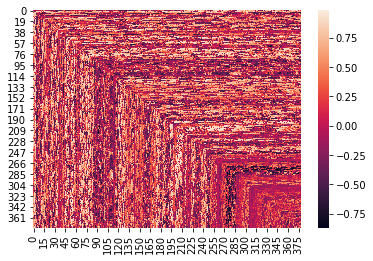

In [29]:
s = 2

sns.heatmap(sp.spatial.distance.squareform(all_fc_data.iloc[s,:]))
plt.show()

# Define CPM functions

In [30]:
subj_list = df.index 

In [203]:

def mk_kfold_indices(subj_list, k = 3):
    """
    Splits list of subjects into k folds for cross-validation.
    """
    
    n_subs = len(subj_list)
    n_subs_per_fold = n_subs//k # floor integer for n_subs_per_fold

    indices = [[fold_no]*n_subs_per_fold for fold_no in range(k)] # generate repmat list of indices
    remainder = n_subs % k # figure out how many subs are left over
    remainder_inds = list(range(remainder))
    indices = [item for sublist in indices for item in sublist]    
    [indices.append(ind) for ind in remainder_inds] # add indices for remainder subs

    assert len(indices)==n_subs, "Length of indices list does not equal number of subjects, something went wrong"

    np.random.shuffle(indices) # shuffles in place

    return np.array(indices)

In [204]:
def split_train_test(subj_list, indices, test_fold):
    """
    For a subj list, k-fold indices, and given fold, returns lists of train_subs and test_subs
    """

    train_inds = np.where(indices!=test_fold)
    test_inds = np.where(indices==test_fold)

    train_subs = []
    for sub in subj_list[train_inds]:
        train_subs.append(sub)

    test_subs = []
    for sub in subj_list[test_inds]:
        test_subs.append(sub)

    return (train_subs, test_subs)

In [205]:
def get_train_test_data(all_fc_data, train_subs, test_subs, behav_data, behav):

    """
    Extracts requested FC and behavioral data for a list of train_subs and test_subs
    """

    train_vcts = all_fc_data.loc[train_subs, :]
    test_vcts = all_fc_data.loc[test_subs, :]

    train_behav = behav_data.loc[train_subs, behav]

    return (train_vcts, train_behav, test_vcts)

In [206]:
def select_features(train_vcts, train_behav, r_thresh=0.2, corr_type='pearson', verbose=False):
    
    """
    Runs the CPM feature selection step: 
    - correlates each edge with behavior, and returns a mask of edges that are correlated above some threshold, one for each tail (positive and negative)
    """

    assert train_vcts.index.equals(train_behav.index), "Row indices of FC vcts and behavior don't match!"

    # Correlate all edges with behav vector
    if corr_type =='pearson':
        cov = np.dot(train_behav.T - train_behav.mean(), train_vcts - train_vcts.mean(axis=0)) / (train_behav.shape[0]-1)
        corr = cov / np.sqrt(np.var(train_behav, ddof=1) * np.var(train_vcts, axis=0, ddof=1))
    elif corr_type =='spearman':
        corr = []
        for edge in train_vcts.columns:
            r_val = sp.stats.spearmanr(train_vcts.loc[:,edge], train_behav)[0]
            corr.append(r_val)

    # Define positive and negative masks
    mask_dict = {}
    mask_dict["pos"] = corr > r_thresh
    mask_dict["neg"] = corr < -r_thresh
    
    if verbose:
        print("Found ({}/{}) edges positively/negatively correlated with behavior in the training set".format(mask_dict["pos"].sum(), mask_dict["neg"].sum())) # for debugging

    return mask_dict

In [207]:
def build_model(train_vcts, mask_dict, train_behav):
    """
    Builds a CPM model:
    - takes a feature mask, sums all edges in the mask for each subject, and uses simple linear regression to relate summed network strength to behavior
    """

    assert train_vcts.index.equals(train_behav.index), "Row indices of FC vcts and behavior don't match!"

    model_dict = {}

    # Loop through pos and neg tails
    X_glm = np.zeros((train_vcts.shape[0], len(mask_dict.items())))

    t = 0
    for tail, mask in mask_dict.items():
        X = train_vcts.values[:, mask].sum(axis=1)
        X_glm[:, t] = X
        y = train_behav
        (slope, intercept) = np.polyfit(X, y, 1)
        model_dict[tail] = (slope, intercept)
        t+=1

    X_glm = np.c_[X_glm, np.ones(X_glm.shape[0])]
    model_dict["glm"] = tuple(np.linalg.lstsq(X_glm, y, rcond=None)[0])

    return model_dict

In [208]:
def apply_model(test_vcts, mask_dict, model_dict):
    """
    Applies a previously trained linear regression model to a test set to generate predictions of behavior.
    """

    behav_pred = {}

    X_glm = np.zeros((test_vcts.shape[0], len(mask_dict.items())))

    # Loop through pos and neg tails
    t = 0
    for tail, mask in mask_dict.items():
        X = test_vcts.loc[:, mask].sum(axis=1)
        X_glm[:, t] = X

        slope, intercept = model_dict[tail]
        behav_pred[tail] = slope*X + intercept
        t+=1

    X_glm = np.c_[X_glm, np.ones(X_glm.shape[0])]
    behav_pred["glm"] = np.dot(X_glm, model_dict["glm"])

    return behav_pred

In [209]:
def cpm_wrapper(all_fc_data, all_behav_data, behav, k=3, **cpm_kwargs):

    assert all_fc_data.index.equals(all_behav_data.index), "Row (subject) indices of FC vcts and behavior don't match!"

    subj_list = all_fc_data.index # get subj_list from df index
    
    indices = mk_kfold_indices(subj_list, k=k)
    
    # Initialize df for storing observed and predicted behavior
    col_list = []
    for tail in ["pos", "neg", "glm"]:
        col_list.append(behav + " predicted (" + tail + ")")
    col_list.append(behav + " observed")
    behav_obs_pred = pd.DataFrame(index=subj_list, columns = col_list)
    
    # Initialize array for storing feature masks
    n_edges = all_fc_data.shape[1]
    all_masks = {}
    all_masks["pos"] = np.zeros((k, n_edges))
    all_masks["neg"] = np.zeros((k, n_edges))
    
    for fold in range(k):
        print("doing fold {}".format(fold))
        train_subs, test_subs = split_train_test(subj_list, indices, test_fold=fold)
        train_vcts, train_behav, test_vcts = get_train_test_data(all_fc_data, train_subs, test_subs, all_behav_data, behav=behav)
        mask_dict = select_features(train_vcts, train_behav, **cpm_kwargs)
        all_masks["pos"][fold,:] = mask_dict["pos"]
        all_masks["neg"][fold,:] = mask_dict["neg"]
        model_dict = build_model(train_vcts, mask_dict, train_behav)
        behav_pred = apply_model(test_vcts, mask_dict, model_dict)
        for tail, predictions in behav_pred.items():
            behav_obs_pred.loc[test_subs, behav + " predicted (" + tail + ")"] = predictions
            
    behav_obs_pred.loc[subj_list, behav + " observed"] = all_behav_data[behav]
    
    return behav_obs_pred, all_masks        

AttributeError: module 'matplotlib' has no attribute 'show'

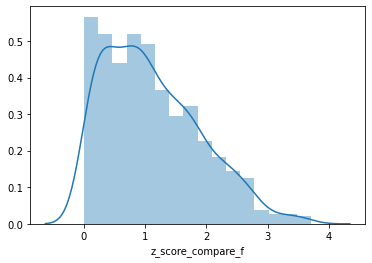

In [31]:
#behav = 'Flanker_AgeAdj'

behav = 'z_score_compare_f'

sns.distplot(df[behav])
plt.show()

In [32]:
cpm_kwargs = {'r_thresh': 0.2, 'corr_type': 'pearson'} # these are the defaults, but it's still good to be explicit

behav_obs_pred, all_masks = cpm_wrapper(all_fc_data, behavior_clean, behav=behav, **cpm_kwargs)

NameError: name 'cpm_wrapper' is not defined

In [127]:
behav_obs_pred.head()

,Flanker_AgeAdj predicted (pos),Flanker_AgeAdj predicted (neg),Flanker_AgeAdj predicted (glm),Flanker_AgeAdj observed
100307,100.191,103.759,102.189,101.9
100408,96.8641,99.9314,94.7975,113.51
101107,105.357,107.374,107.205,96.19
101309,99.9672,100.591,98.5256,103.37
101915,103.077,103.147,103.399,89.1


In [128]:
def plot_predictions(behav_obs_pred, tail="glm"):
    x = behav_obs_pred.filter(regex=("obs")).astype(float)
    y = behav_obs_pred.filter(regex=(tail)).astype(float)

    g = sns.regplot(x=x.T.squeeze(), y=y.T.squeeze(), color='gray')
    ax_min = min(min(g.get_xlim()), min(g.get_ylim()))
    ax_max = max(max(g.get_xlim()), max(g.get_ylim()))
    g.set_xlim(ax_min, ax_max)
    g.set_ylim(ax_min, ax_max)
    g.set_aspect('equal', adjustable='box')
    
    r = sp.stats.pearsonr(x,y)[0][0]
    g.annotate('r = {0:.2f}'.format(r), xy = (0.7, 0.1), xycoords = 'axes fraction')
    
    return g

TypeError: No loop matching the specified signature and casting was found for ufunc add

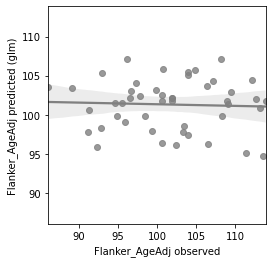

In [129]:
g = plot_predictions(behav_obs_pred)
g.set_title(condition)
plt.show()